### Kaggle bootstrapping

In [1]:
# Kaggle COMPETITION bootstrapping
COMPETITION_NAME = 'nlp-getting-started'

!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get competition data
if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


In [2]:
!ls {path}

models	sample_submission.csv  test.csv  train.csv


### Explore the data

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [5]:
df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [6]:
df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [7]:
df.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [8]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# sample non-disaster tweet
df[df.target == 0].text.values[0]

"What's up man?"

In [10]:
# sample disaster tweet
df[df.target == 1].text.values[1]

'Forest fire near La Ronge Sask. Canada'

### Data cleanup

In [11]:
# TODO

### Preprocess the data

In [12]:
df['text_len'] = df.text.str.len()
df

,id,keyword,location,text,target,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,137


In [18]:
df[~df.keyword.isna() & ~df.location.isna()].head()

,id,keyword,location,text,target,text_len
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1,55
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0,67
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1,82
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0,76


In [21]:
def preprocess(df):
    df.keyword.fillna('none', inplace=True)
    df.location.fillna('unknown', inplace=True)
    df['rich_text'] = 'keyword: ' + df.keyword + '; location: ' + df.location +'; tweet: ' + df.text
    return df

In [22]:
df = preprocess(df)
df.head()

,id,keyword,location,text,target,text_len,rich_text
0,1,none,unknown,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,keyword: none; location: unknown; tweet: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,4,none,unknown,Forest fire near La Ronge Sask. Canada,1,38,keyword: none; location: unknown; tweet: Forest fire near La Ronge Sask. Canada
2,5,none,unknown,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,keyword: none; location: unknown; tweet: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,6,none,unknown,"13,000 people receive #wildfires evacuation orders in California",1,65,"keyword: none; location: unknown; tweet: 13,000 people receive #wildfires evacuation orders in California"
4,7,none,unknown,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,keyword: none; location: unknown; tweet: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [23]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_len', 'rich_text'], dtype='object')

### Let's try using fastai for NLP!

In [24]:
from fastai.text.all import *

In [25]:
dls = TextDataLoaders.from_df(df, path, text_col='rich_text', label_col='target')

In [26]:
dls.show_batch()

,text,category
0,xxbos keyword : mayhem ; location : ? ? xxmaj made in the xxmaj philippines ? ? ; tweet : _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos keyword : terrorism ; location : unknown ; tweet : xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1
2,xxbos keyword : terrorism ; location : unknown ; tweet : xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0
3,xxbos keyword : hostages ; location : unknown ; tweet : xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
4,xxbos keyword : hostages ; location : unknown ; tweet : xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
5,xxbos keyword : explode ; location : unknown ; tweet : xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxup xxunk xxmaj please # xxup rt,0
6,xxbos keyword : explode ; location : unknown ; tweet : xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0
7,xxbos keyword : explode ; location : unknown ; tweet : xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0
8,xxbos keyword : fire ; location : xxmaj to xxmaj the xxmaj right of xxmaj you ! ; tweet : xxmaj xxunk : xxmaj harry xxmaj reid 's ' 30 xxmaj percent of xxmaj women xxmaj served ' xxmaj planned xxmaj parenthood xxmaj claim xxmaj is a ' pants on xxmaj fire ' xxmaj lie http : / / t.co / xxunk | # tcot,0


In [35]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

SuggestedLRs(valley=0.0020892962347716093)

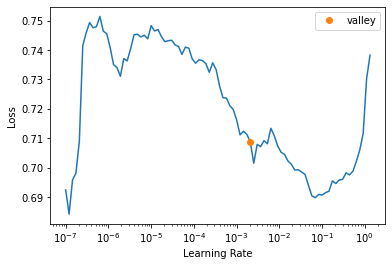

In [33]:
learn.lr_find()

In [36]:
learn.fine_tune(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.639467,0.568311,0.689225,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.570716,0.484787,0.787122,00:10
1,0.527533,0.451919,0.806176,00:10
2,0.489406,0.437839,0.814717,00:10
3,0.455183,0.439813,0.819317,00:10
4,0.438329,0.428208,0.818660,00:10


In [37]:
learn.show_results()

,text,category,category_
0,xxbos keyword : army ; location : xxmaj pakistan ; tweet : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0,1
1,xxbos keyword : weapon ; location : xxmaj washington xxup dc ; tweet : xxmaj rare xxunk into # terror and xxmaj how to fight it http : / / t.co / xxunk # xxmaj cameroon # xxup usa # xxmaj xxunk # xxup xxunk # xxup fr # xxmaj nigeria # xxup uk # xxmaj africa # xxup de # xxup ca # xxup au # xxup xxunk,1,1
2,xxbos keyword : terrorism ; location : unknown ; tweet : xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0,1
3,xxbos keyword : screamed ; location : ' san xxup xxunk xxrep 5 o ' ; tweet : xxunk i xxup screamed xxup at xxup the xxup top xxup of xxup my xxup lungs xxup when xxup you xxup said xxup you xxup guys xxup would xxup come xxup back xxup to xxup xxunk xxup so xxup keep xxup your xxup promise # xxunk,0,0
4,xxbos keyword : rubble ; location : xxmaj spain - xxmaj china - xxmaj latin xxmaj america . ; tweet : xxmaj china 's xxmaj stock xxmaj market xxmaj crash : xxmaj are xxmaj there xxmaj gems xxmaj in xxmaj the xxmaj rubble ? : xxmaj chinaûªs stock market crash this summer h … http : / / t.co / xxunk by xxunk,0,0
5,"xxbos keyword : body%20bag ; location : xxmaj california , xxup usa ; tweet : xxunk } xxmaj new xxmaj ladies xxmaj shoulder xxmaj tote # xxmaj handbag xxmaj faux xxmaj leather xxmaj hobo xxmaj purse xxmaj cross xxmaj body xxmaj bag # xxmaj womens http : / / t.co / xxunk http : / / t.co / xxunk xxup rt xxunk _",0,0
6,xxbos keyword : volcano ; location : ? xxrep 7 ? ? ( ? ? å ¡ ? ? ? å ¡ ) ; tweet : xxunk a xxmaj dragon 's belly . xxmaj or an ice cave under \n a volcano in xxmaj xxunk | xxmaj photography by \n å © daniel xxmaj xxunk \n http : / / t.co / xxunk,1,0
7,"xxbos keyword : refugees ; location : xxup nyc , us - xxmaj cali , xxmaj colombia ; tweet : xxmaj the xxmaj most xxmaj xxunk xxmaj bride on xxmaj earth : xxmaj couple xxmaj xxunk 4 xxrep 3 0 xxmaj syrian xxmaj refugees on xxmaj their xxmaj wedding xxmaj day http : / / t.co / xxunk via xxunk love it !",0,0
8,xxbos keyword : massacre ; location : unknown ; tweet : xxmaj the xxmaj fake of xxmaj xxunk xxmaj xxunk xxmaj xxunk ( english ): http : / / t.co / xxunk # xxmaj obama # xxmaj clinton # xxmaj bush # xxup gop # xxup abc # xxup xxunk # xxup bbc # xxup cnn # xxup xxunk # xxup xxunk,1,0


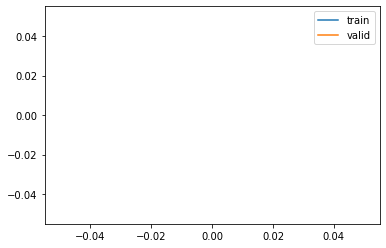

In [38]:
learn.recorder.plot_loss()

### predictions for test data

In [39]:
test_df = pd.read_csv(path/'test.csv')
test_df = preprocess(test_df)
test_df.head()

,id,keyword,location,text,rich_text
0,0,none,unknown,Just happened a terrible car crash,keyword: none; location: unknown; tweet: Just happened a terrible car crash
1,2,none,unknown,"Heard about #earthquake is different cities, stay safe everyone.","keyword: none; location: unknown; tweet: Heard about #earthquake is different cities, stay safe everyone."
2,3,none,unknown,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","keyword: none; location: unknown; tweet: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,none,unknown,Apocalypse lighting. #Spokane #wildfires,keyword: none; location: unknown; tweet: Apocalypse lighting. #Spokane #wildfires
4,11,none,unknown,Typhoon Soudelor kills 28 in China and Taiwan,keyword: none; location: unknown; tweet: Typhoon Soudelor kills 28 in China and Taiwan


In [40]:
test_dl = dls.test_dl(test_df)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [41]:
decoded.shape

torch.Size([3263])

In [42]:
decoded.float().mean()

tensor(0.2737)

### Submission

In [43]:
submission = pd.read_csv(path/'sample_submission.csv')
submission.shape

(3263, 2)

In [44]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [45]:
submission.target = decoded
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [46]:
test_df.head()

,id,keyword,location,text,rich_text
0,0,none,unknown,Just happened a terrible car crash,keyword: none; location: unknown; tweet: Just happened a terrible car crash
1,2,none,unknown,"Heard about #earthquake is different cities, stay safe everyone.","keyword: none; location: unknown; tweet: Heard about #earthquake is different cities, stay safe everyone."
2,3,none,unknown,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","keyword: none; location: unknown; tweet: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,none,unknown,Apocalypse lighting. #Spokane #wildfires,keyword: none; location: unknown; tweet: Apocalypse lighting. #Spokane #wildfires
4,11,none,unknown,Typhoon Soudelor kills 28 in China and Taiwan,keyword: none; location: unknown; tweet: Typhoon Soudelor kills 28 in China and Taiwan


### send submission to Kaggle!

In [48]:
# write submission csv
technique = '-more-input-fastai-learner'
sub_filename = Path('subs')/(COMPETITION_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)

if not iskaggle:
    print('about to submit', sub_filename, 'to kaggle')
    input('continue?')
    ret = kaggle.api.competition_submit(sub_filename, technique, COMPETITION_NAME)
    print(ret)

about to submit subs/nlp-getting-started--more-input-fastai-learner-sub.csv to kaggle


continue? y


100%|██████████| 22.2k/22.2k [00:00<00:00, 46.2kB/s]


Successfully submitted to Natural Language Processing with Disaster Tweets
